[warn] Strict full load failed: RuntimeError('Error(s) in loading state_dict for TimeSformerClassifier:\n\tMissing key(s) in state_dict: "classifier.weight", "classifier.bias". \n\tUnexpected key(s) in state_dict: "classifier.0.weight", "classifier.0.bias", "classifier.1.weight", "classifier.1.bias". ')
[info] Non-strict load. Missing: ['classifier.weight', 'classifier.bias'] Unexpected: ['classifier.0.weight', 'classifier.0.bias', 'classifier.1.weight', 'classifier.1.bias']
[info] Extracting train features...


Extract: 100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


[info] Extracting test features...


Extract: 100%|██████████| 1/1 [00:10<00:00, 10.22s/it]



[kNN on latent] classification report (test):
              precision    recall  f1-score   support

           0      1.000     0.933     0.966        15
           1      1.000     1.000     1.000        15
           2      0.481     0.867     0.619        15
           3      1.000     1.000     1.000        15
           4      1.000     1.000     1.000        15
           5      0.500     0.133     0.211        15
           6      1.000     1.000     1.000        15
           7      1.000     1.000     1.000        15

    accuracy                          0.867       120
   macro avg      0.873     0.867     0.849       120
weighted avg      0.873     0.867     0.849       120



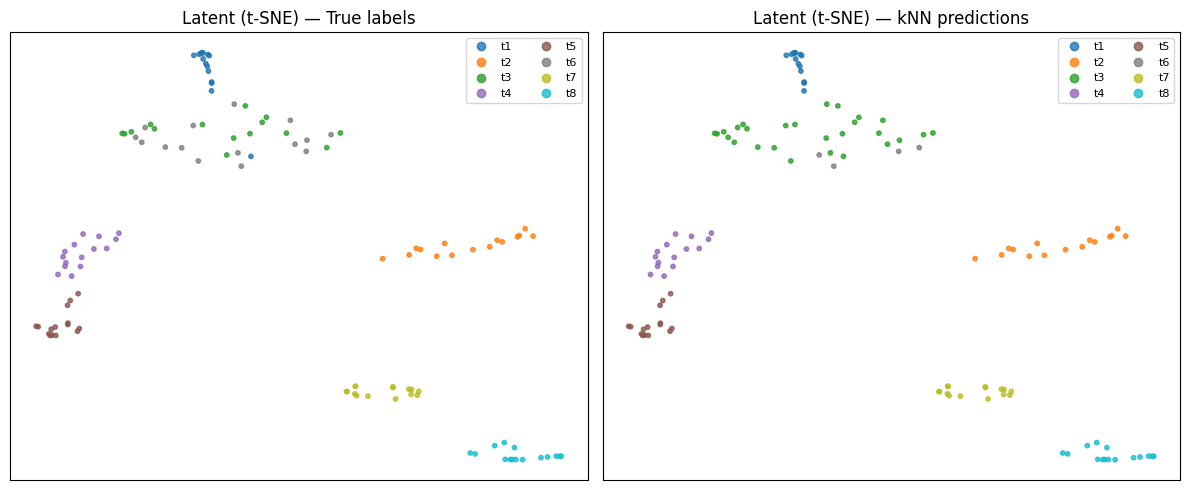

In [1]:
# %% Latent-space visualization (t-SNE) with kNN on your trained model
# Requires: scikit-learn, matplotlib, tqdm
#   pip install scikit-learn matplotlib tqdm

import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

from load_data import create_dataloaders, CFG
from timesformer_min import TimeSformerEncoder

# ----------------------------
# Model wrapper (encoder + optional classifier)
# ----------------------------
class TimeSformerClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.encoder = TimeSformerEncoder(
            in_ch=1, embed_dim=384, depth=6, num_heads=6,
            mlp_ratio=4.0, drop=0.1, attn_drop=0.0,
            patch=(8,8), T=7, H=32, W=64
        )
        # infer feature dim once
        with torch.no_grad():
            dummy = torch.zeros(2, 7, 1, 32, 64)
            feat_dim = self.encoder(dummy).shape[-1]
        self.classifier = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        # x: [B,T,1,H,W]
        h = self.encoder(x)
        logits = self.classifier(h)
        return logits, h  # also return features


def load_checkpoint_safely(model: nn.Module, ckpt_path: str):
    """
    Try loading a full classifier checkpoint; if that fails,
    try loading encoder-only weights.
    """
    sd = torch.load(ckpt_path, map_location="cpu")
    if isinstance(sd, dict) and "state_dict" in sd:
        sd = sd["state_dict"]

    # First attempt: strict full load
    try:
        model.load_state_dict(sd, strict=True)
        print("[info] Loaded checkpoint strictly into full model.")
        return
    except Exception as e:
        print("[warn] Strict full load failed:", repr(e))

    # Second attempt: non-strict
    try:
        missing, unexpected = model.load_state_dict(sd, strict=False)
        print("[info] Non-strict load. Missing:", missing, "Unexpected:", unexpected)
        return
    except Exception as e:
        print("[warn] Non-strict full load failed:", repr(e))

    # Third attempt: try encoder-only keys (common patterns)
    enc = model.encoder.state_dict()
    subkeys = [k for k in sd.keys() if k.startswith("encoder.") or k.startswith("module.encoder.")]
    if subkeys:
        # Remap possible 'module.' prefix
        enc_sd = {}
        for k, v in sd.items():
            if k.startswith("module.encoder."):
                enc_sd[k[len("module.encoder."):]] = v
            elif k.startswith("encoder."):
                enc_sd[k[len("encoder."):]] = v
        missing, unexpected = model.encoder.load_state_dict(enc_sd, strict=False)
        print("[info] Loaded encoder-only weights (non-strict). Missing:", missing, "Unexpected:", unexpected)
        return

    # Last resort: try raw dict into encoder
    try:
        missing, unexpected = model.encoder.load_state_dict(sd, strict=False)
        print("[info] Loaded raw dict into encoder (non-strict). Missing:", missing, "Unexpected:", unexpected)
    except Exception as e:
        print("[error] Could not load checkpoint in any mode:", repr(e))


# ----------------------------
# Feature extraction
# ----------------------------
@torch.no_grad()
def extract_features(model: TimeSformerClassifier, loader, device="cuda"):
    model.eval()
    feats, labels = [], []
    for batch in tqdm(loader, desc="Extract"):
        x = batch["video"].to(device, non_blocking=True)  # [B,T,1,32,64]
        y = batch["label"].cpu().numpy()
        _, h = model(x)  # logits not needed, use latent h
        feats.append(h.cpu().numpy())
        labels.append(y)
    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labels, axis=0)
    return X, y

# ----------------------------
# kNN + t-SNE plotting (single embedding)
# ----------------------------
def plot_tsne_side_by_side(X_test_2d, y_true, y_pred, num_classes=8, title_left="True labels", title_right="kNN predictions"):
    plt.figure(figsize=(12, 5))

    # consistent color mapping 0..num_classes-1
    cmap = plt.get_cmap("tab10" if num_classes <= 10 else "tab20")

    ax1 = plt.subplot(1, 2, 1)
    sc1 = ax1.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_true, s=10, cmap=cmap, alpha=0.8)
    ax1.set_title(title_left)
    ax1.set_xticks([]); ax1.set_yticks([])
    # legend
    handles1, labels1 = sc1.legend_elements(num=num_classes)
    ax1.legend(handles1, [f"t{i+1}" for i in range(num_classes)], loc="best", fontsize=8, ncol=2)

    ax2 = plt.subplot(1, 2, 2)
    sc2 = ax2.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, s=10, cmap=cmap, alpha=0.8)
    ax2.set_title(title_right)
    ax2.set_xticks([]); ax2.set_yticks([])
    handles2, labels2 = sc2.legend_elements(num=num_classes)
    ax2.legend(handles2, [f"t{i+1}" for i in range(num_classes)], loc="best", fontsize=8, ncol=2)

    plt.tight_layout()
    plt.show()

# ----------------------------
# Main
# ----------------------------
def main():
    # 1) Data
    #    Uses CFG from load_data.py — ensure CFG.root points to your panos folder.
    dl_train, dl_val, dl_test = create_dataloaders(CFG, batch_size=128, num_workers=4)

    # 2) Model + checkpoint
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = TimeSformerClassifier(num_classes=8).to(device)

    ckpt_path = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\models\timesformer_cls_30.pth"
    if os.path.isfile(ckpt_path):
        load_checkpoint_safely(model, ckpt_path)
    else:
        print(f"[warn] Checkpoint not found at:\n  {ckpt_path}\nProceeding with randomly initialized classifier (encoder still defined).")

    # 3) Extract features
    print("[info] Extracting train features...")
    X_train, y_train = extract_features(model, dl_train, device=device)
    print("[info] Extracting test features...")
    X_test,  y_test  = extract_features(model, dl_test, device=device)

    # 4) Train kNN on train features, predict test
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import classification_report

    knn = KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print("\n[kNN on latent] classification report (test):")
    print(classification_report(y_test, y_pred, digits=3))

    # 5) t-SNE on TEST features ONLY (single embedding for both plots)
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
    X_test_2d = tsne.fit_transform(X_test)

    # 6) Plot side-by-side using SAME embedding
    plot_tsne_side_by_side(X_test_2d, y_true=y_test, y_pred=y_pred, num_classes=8,
                           title_left="Latent (t-SNE) — True labels",
                           title_right="Latent (t-SNE) — kNN predictions")

if __name__ == "__main__":
    main()
